In [2]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns


In [3]:
import geopandas as gpd
import pandas as pd
from sklearn.model_selection import train_test_split

# Veri setini oku (önceden kaydetmiştik)
cities_proj = gpd.read_file("../data/processed/cities_proj.geojson")

# EPSG:4326'a dönüştür
cities_deg = cities_proj.to_crs(epsg=4326).copy()

# Kıta etiketlemesi
def assign_continent(row):
    x, y = row.geometry.x, row.geometry.y
    if -30 <= x <= 50 and 35 <= y <= 70:
        return 'Europe'
    elif 50 <= x <= 150 and 0 <= y <= 60:
        return 'Asia'
    elif -170 <= x <= -30 and 10 <= y <= 80:
        return 'North America'
    elif -20 <= x <= 50 and -35 <= y <= 35:
        return 'Africa'
    elif -80 <= x <= -30 and -60 <= y <= -10:
        return 'South America'
    elif 110 <= x <= 180 and -50 <= y <= -10:
        return 'Australia'
    else:
        return 'Other'

cities_deg['continent'] = cities_deg.apply(assign_continent, axis=1)
cities_deg['near_meteor'] = (cities_deg['min_meteor_distance_m'] < 500_000).astype(int)

# Dummies dönüşümü
clean_data = pd.get_dummies(cities_deg, columns=['continent'], drop_first=True)

# X ve y oluştur
feature_cols = ['min_meteor_distance_m'] + [col for col in clean_data.columns if col.startswith('continent_')]
X = clean_data[feature_cols]
y = clean_data['near_meteor']

# Eğitim/Test ayrımı
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# 🔹 Temel Sınıflandırm


### Logistic Regression

### LDA (Linear Discriminant Analysis)

### GAM (Generalized Additive Models)
a

🔍 Logistic Regression (mesafe olmadan):
Accuracy :  0.730
Precision:  0.800
Recall   :  0.606
F1 Score :  0.690


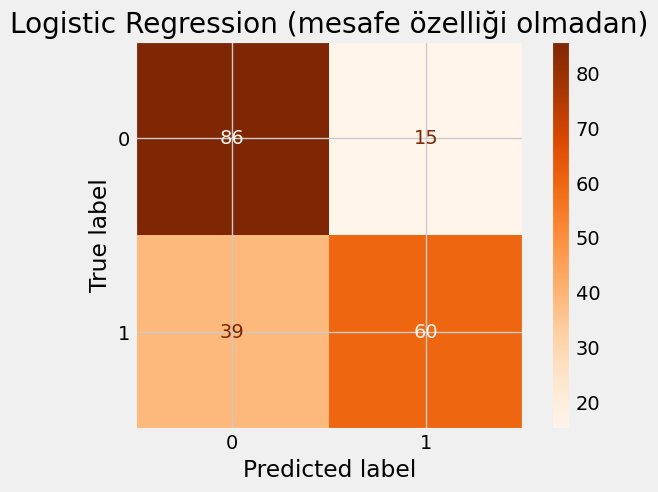

In [12]:
#Logistic Regression

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# 1️⃣ min_meteor_distance_m olmadan yeni X seti
feature_cols = [col for col in clean_data.columns if col.startswith('continent_')]
X_no_distance = clean_data[feature_cols]
y = clean_data['near_meteor']

# 2️⃣ Eğitim/test seti oluştur
X_train, X_test, y_train, y_test = train_test_split(X_no_distance, y, test_size=0.2, random_state=42)

# 3️⃣ Modeli tanımla ve eğit
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train, y_train)

# 4️⃣ Tahmin ve değerlendirme
y_pred = log_reg.predict(X_test)

acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, zero_division=0)
rec = recall_score(y_test, y_pred, zero_division=0)
f1 = f1_score(y_test, y_pred, zero_division=0)

print("🔍 Logistic Regression (mesafe olmadan):")
print(f"Accuracy :  {acc:.3f}")
print(f"Precision:  {prec:.3f}")
print(f"Recall   :  {rec:.3f}")
print(f"F1 Score :  {f1:.3f}")

# 5️⃣ Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Oranges")
plt.title("Logistic Regression (mesafe özelliği olmadan)")
plt.show()


🔍 Linear Discriminant Analysis (LDA):
Accuracy :  0.856
Precision:  0.891
Recall   :  0.949
F1 Score :  0.919


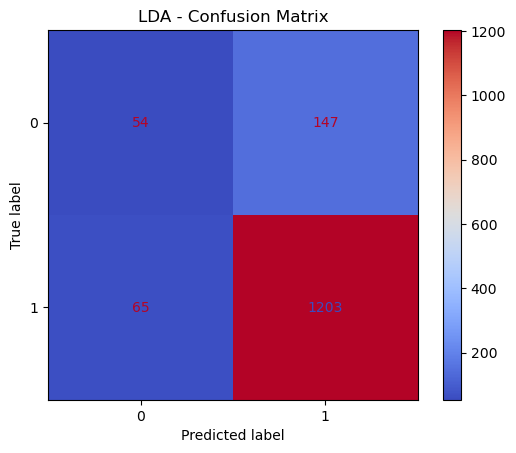

In [6]:
#LDA (Linear Discriminant Analysis)

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# 1️⃣ Model tanımı ve eğitim
lda = LinearDiscriminantAnalysis()
lda.fit(X_train, y_train)

# 2️⃣ Tahminler
y_pred_lda = lda.predict(X_test)

# 3️⃣ Performans metrikleri
acc = accuracy_score(y_test, y_pred_lda)
prec = precision_score(y_test, y_pred_lda, zero_division=0)
rec = recall_score(y_test, y_pred_lda, zero_division=0)
f1 = f1_score(y_test, y_pred_lda, zero_division=0)

print("🔍 Linear Discriminant Analysis (LDA):")
print(f"Accuracy :  {acc:.3f}")
print(f"Precision:  {prec:.3f}")
print(f"Recall   :  {rec:.3f}")
print(f"F1 Score :  {f1:.3f}")

# 4️⃣ Confusion Matrix görselleştirme
cm = confusion_matrix(y_test, y_pred_lda)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="coolwarm")
plt.title("LDA - Confusion Matrix")
plt.show()


🔍 Generalized Additive Model (GAM):
Accuracy :  0.863
Precision:  0.863
Recall   :  1.000
F1 Score :  0.927


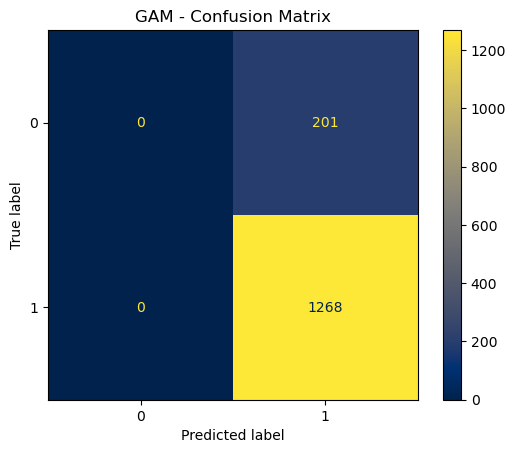

In [8]:
#GAM (Generalized Additive Models)

from pygam import LogisticGAM, s, f

# 1️⃣ GAM için terim yapısını oluştur (mesafe spline, kıtalar faktör)
terms = s(0)  # 0. sütun: min_meteor_distance_m
for i in range(1, X_train.shape[1]):  # Diğer sütunlar: continent_...
    terms += f(i)

# 2️⃣ GAM modelini eğit
gam = LogisticGAM(terms).fit(X_train, y_train)

# 3️⃣ Tahmin ve değerlendirme
y_pred_proba = gam.predict(X_test)
y_pred_class = (y_pred_proba > 0.5).astype(int)

acc = accuracy_score(y_test, y_pred_class)
prec = precision_score(y_test, y_pred_class, zero_division=0)
rec = recall_score(y_test, y_pred_class, zero_division=0)
f1 = f1_score(y_test, y_pred_class, zero_division=0)

print("🔍 Generalized Additive Model (GAM):")
print(f"Accuracy :  {acc:.3f}")
print(f"Precision:  {prec:.3f}")
print(f"Recall   :  {rec:.3f}")
print(f"F1 Score :  {f1:.3f}")

# 4️⃣ Confusion Matrix görselleştirme
cm = confusion_matrix(y_test, y_pred_class)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="cividis")
plt.title("GAM - Confusion Matrix")
plt.show()


# 🔹 Ağaç Temelli Modeller

### Decision Tree

### Random Forest

### XGBoost

### LightGBM

### CatBoost

### ExtraTrees

🔍 Decision Tree (mesafe olmadan):
Accuracy :  0.863
Precision:  0.863
Recall   :  1.000
F1 Score :  0.927


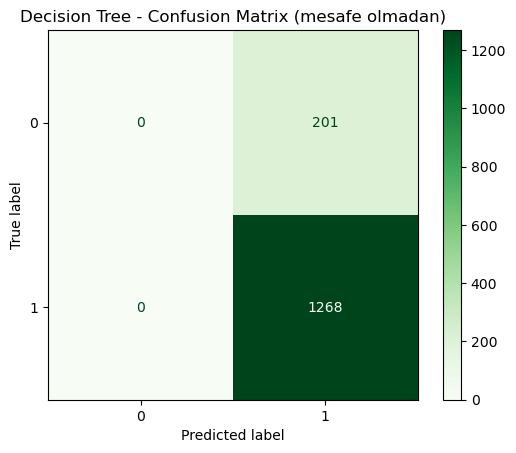

In [10]:
from sklearn.tree import DecisionTreeClassifier

# 1️⃣ Model tanımı
tree = DecisionTreeClassifier(random_state=42)

# 2️⃣ Eğit
tree.fit(X_train, y_train)

# 3️⃣ Tahmin ve değerlendirme
y_pred_tree = tree.predict(X_test)

acc = accuracy_score(y_test, y_pred_tree)
prec = precision_score(y_test, y_pred_tree, zero_division=0)
rec = recall_score(y_test, y_pred_tree, zero_division=0)
f1 = f1_score(y_test, y_pred_tree, zero_division=0)

print("🔍 Decision Tree (mesafe olmadan):")
print(f"Accuracy :  {acc:.3f}")
print(f"Precision:  {prec:.3f}")
print(f"Recall   :  {rec:.3f}")
print(f"F1 Score :  {f1:.3f}")

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_tree)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Greens")
plt.title("Decision Tree - Confusion Matrix (mesafe olmadan)")
plt.show()


🔍 Random Forest (mesafe olmadan):
Accuracy :  0.863
Precision:  0.863
Recall   :  1.000
F1 Score :  0.927


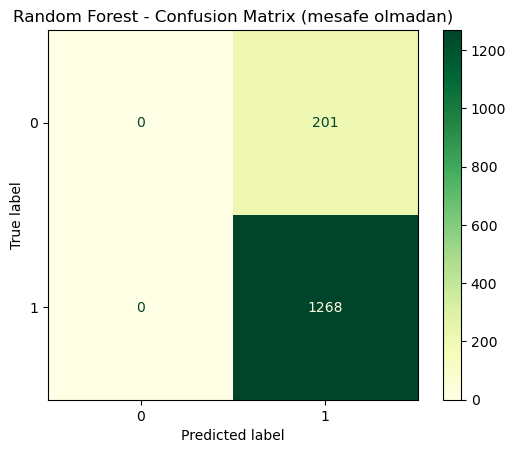

In [11]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)

acc = accuracy_score(y_test, y_pred_rf)
prec = precision_score(y_test, y_pred_rf, zero_division=0)
rec = recall_score(y_test, y_pred_rf, zero_division=0)
f1 = f1_score(y_test, y_pred_rf, zero_division=0)

print("🔍 Random Forest (mesafe olmadan):")
print(f"Accuracy :  {acc:.3f}")
print(f"Precision:  {prec:.3f}")
print(f"Recall   :  {rec:.3f}")
print(f"F1 Score :  {f1:.3f}")

cm = confusion_matrix(y_test, y_pred_rf)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="YlGn")
plt.title("Random Forest - Confusion Matrix (mesafe olmadan)")
plt.show()


🔍 XGBoost (mesafe olmadan):
Accuracy :  0.863
Precision:  0.863
Recall   :  1.000
F1 Score :  0.927


C:\Users\yalaz\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [19:06:44] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


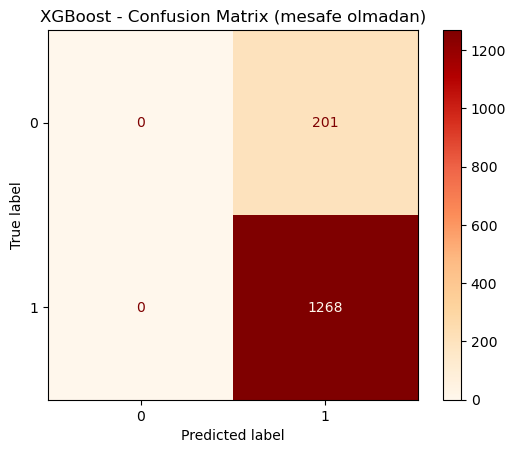

In [12]:
from xgboost import XGBClassifier

xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb.fit(X_train, y_train)

y_pred_xgb = xgb.predict(X_test)

acc = accuracy_score(y_test, y_pred_xgb)
prec = precision_score(y_test, y_pred_xgb, zero_division=0)
rec = recall_score(y_test, y_pred_xgb, zero_division=0)
f1 = f1_score(y_test, y_pred_xgb, zero_division=0)

print("🔍 XGBoost (mesafe olmadan):")
print(f"Accuracy :  {acc:.3f}")
print(f"Precision:  {prec:.3f}")
print(f"Recall   :  {rec:.3f}")
print(f"F1 Score :  {f1:.3f}")

cm = confusion_matrix(y_test, y_pred_xgb)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="OrRd")
plt.title("XGBoost - Confusion Matrix (mesafe olmadan)")
plt.show()


🔍 LightGBM (Dengelenmiş, Temiz Başlangıç):
Accuracy :  0.607
Precision:  0.938
Recall   :  0.584
F1 Score :  0.719


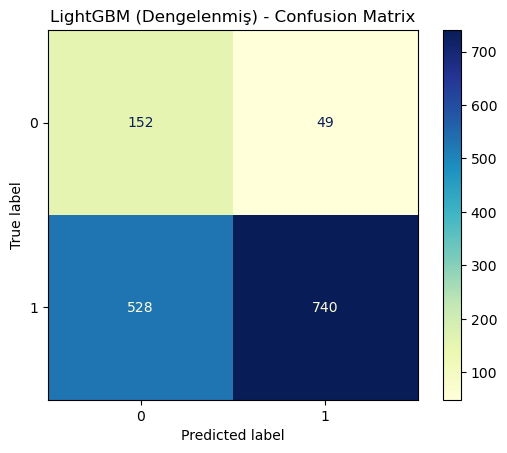

In [17]:
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# 1️⃣ Kolon adlarındaki boşlukları temizle (gerekirse)
X_train.columns = [col.replace(" ", "_") for col in X_train.columns]
X_test.columns = [col.replace(" ", "_") for col in X_test.columns]

# 2️⃣ LightGBM modelini tanımla (class_weight ile)
lgbm_model = LGBMClassifier(
    class_weight='balanced',  # sınıf dengesizliğini düzelt
    random_state=42,
    verbose=-1  # uyarıları bastır
)

# 3️⃣ Modeli eğit
lgbm_model.fit(X_train, y_train)

# 4️⃣ Tahminler
y_pred = lgbm_model.predict(X_test)

# 5️⃣ Performans metrikleri
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, zero_division=0)
rec = recall_score(y_test, y_pred, zero_division=0)
f1 = f1_score(y_test, y_pred, zero_division=0)

print("🔍 LightGBM (Dengelenmiş, Temiz Başlangıç):")
print(f"Accuracy :  {acc:.3f}")
print(f"Precision:  {prec:.3f}")
print(f"Recall   :  {rec:.3f}")
print(f"F1 Score :  {f1:.3f}")

# 6️⃣ Confusion Matrix görselleştir
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="YlGnBu")
plt.title("LightGBM (Dengelenmiş) - Confusion Matrix")
plt.show()


🔍 CatBoost Classifier:
Accuracy :  0.607
Precision:  0.938
Recall   :  0.584
F1 Score :  0.719


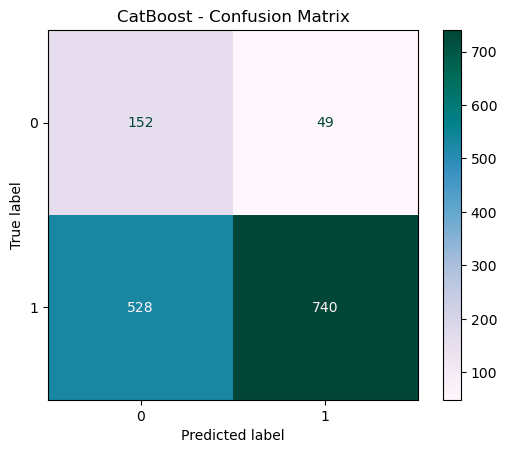

In [18]:
from catboost import CatBoostClassifier

# 1️⃣ Model tanımı (sessiz modda)
cat_model = CatBoostClassifier(verbose=0, random_seed=42, class_weights=[1, len(y_train[y_train==0]) / len(y_train[y_train==1])])

# 2️⃣ Modeli eğit
cat_model.fit(X_train, y_train)

# 3️⃣ Tahmin
y_pred_cat = cat_model.predict(X_test)

# 4️⃣ Performans metrikleri
acc = accuracy_score(y_test, y_pred_cat)
prec = precision_score(y_test, y_pred_cat, zero_division=0)
rec = recall_score(y_test, y_pred_cat, zero_division=0)
f1 = f1_score(y_test, y_pred_cat, zero_division=0)

print("🔍 CatBoost Classifier:")
print(f"Accuracy :  {acc:.3f}")
print(f"Precision:  {prec:.3f}")
print(f"Recall   :  {rec:.3f}")
print(f"F1 Score :  {f1:.3f}")

# 5️⃣ Confusion Matrix
cm = confusion_matrix(y_test, y_pred_cat)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="PuBuGn")
plt.title("CatBoost - Confusion Matrix")
plt.show()


🔍 Extra Trees Classifier:
Accuracy :  0.607
Precision:  0.938
Recall   :  0.584
F1 Score :  0.719


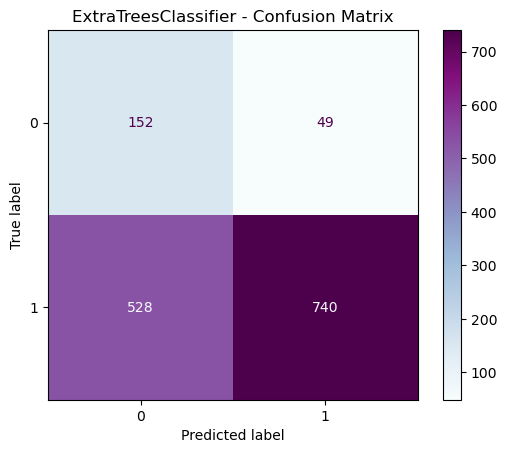

In [19]:
from sklearn.ensemble import ExtraTreesClassifier

# 1️⃣ Model tanımı
et_model = ExtraTreesClassifier(class_weight='balanced', random_state=42)

# 2️⃣ Eğit
et_model.fit(X_train, y_train)

# 3️⃣ Tahmin
y_pred_et = et_model.predict(X_test)

# 4️⃣ Performans metrikleri
acc = accuracy_score(y_test, y_pred_et)
prec = precision_score(y_test, y_pred_et, zero_division=0)
rec = recall_score(y_test, y_pred_et, zero_division=0)
f1 = f1_score(y_test, y_pred_et, zero_division=0)

print("🔍 Extra Trees Classifier:")
print(f"Accuracy :  {acc:.3f}")
print(f"Precision:  {prec:.3f}")
print(f"Recall   :  {rec:.3f}")
print(f"F1 Score :  {f1:.3f}")

# 5️⃣ Confusion Matrix
cm = confusion_matrix(y_test, y_pred_et)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="BuPu")
plt.title("ExtraTreesClassifier - Confusion Matrix")
plt.show()


# 🔹 Yoğunluk / Kümeleme

### DBSCAN

### HDBSCAN

### MeanShift

### OPTICS



dbscan_cluster
-1      564
 0      418
 1       23
 2      460
 3       29
 4      118
 5       47
 6     1749
 7     6214
 8       57
 9      274
 10    1509
 11      11
 12     618
 13      39
 14      10
 15      17
 16      19
 17      27
 18      46
 19      13
 20     583
 21      12
 22      16
 23     233
 24    3150
 25    6146
 26    1509
 27    5588
 28      38
 29     218
 30     185
 31    2494
 32      10
 33     909
 34       8
 35      10
 36      26
 37      12
 38      71
 39      33
 40    4888
Name: count, dtype: int64


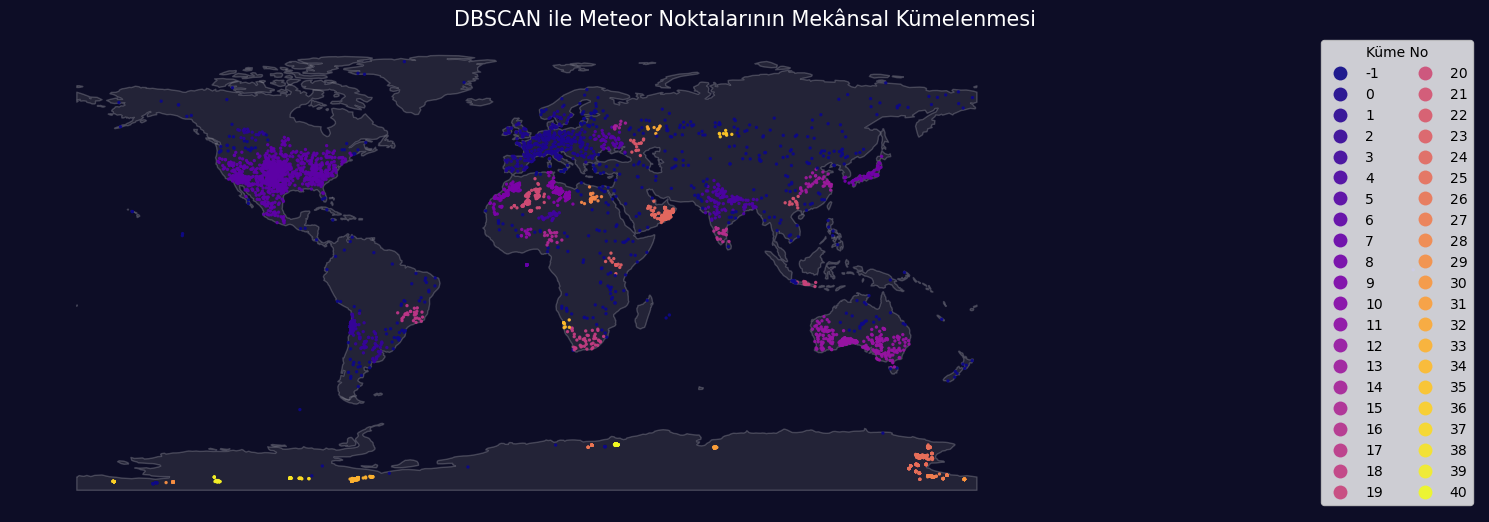

In [23]:
import geopandas as gpd

meteor_gdf = gpd.read_file("../data/processed/meteor_gdf.geojson")

from sklearn.cluster import DBSCAN
import numpy as np

# 1️⃣ Koordinatları numpy dizisine çevir (EPSG:4326 kullan)
coords = np.array(list(zip(meteor_gdf.geometry.x, meteor_gdf.geometry.y)))

# 2️⃣ DBSCAN modeli
# eps: iki nokta arasındaki maksimum mesafe (derece cinsinden)
# min_samples: bir küme oluşması için gereken minimum nokta sayısı
db = DBSCAN(eps=3, min_samples=10).fit(coords)

# 3️⃣ Küme etiketlerini meteor_gdf'e ekle
meteor_gdf['dbscan_cluster'] = db.labels_

# Küme ID'lerinin dağılımını incele
print(meteor_gdf['dbscan_cluster'].value_counts().sort_index())

import matplotlib.pyplot as plt
import geopandas as gpd
from geodatasets import get_path

# Dünya haritası verisini oku
world = gpd.read_file(get_path("naturalearth.land"))

# Haritayı çiz
fig, ax = plt.subplots(figsize=(15, 15))
fig.patch.set_facecolor('#0d0d26')  # Uzay temalı arka plan

# Dünya sınırlarını çiz
world.plot(ax=ax, color='gray', edgecolor='white', alpha=0.2)

# Meteor DBSCAN kümeleri
meteor_gdf.plot(
    ax=ax,
    column='dbscan_cluster',
    categorical=True,
    legend=True,
    cmap='plasma',
    markersize=2,
    alpha=0.9,
    legend_kwds={
        'loc': 'lower right',
        'bbox_to_anchor': (1, 0),
        'frameon': True,
        'ncol': 2,
        'title': 'Küme No'
    }
)

plt.title("DBSCAN ile Meteor Noktalarının Mekânsal Kümelenmesi", fontsize=15, color='white')
ax.set_facecolor('#0d0d26')
ax.tick_params(colors='white')
plt.grid(False)
plt.axis('off')
plt.tight_layout()
plt.show()



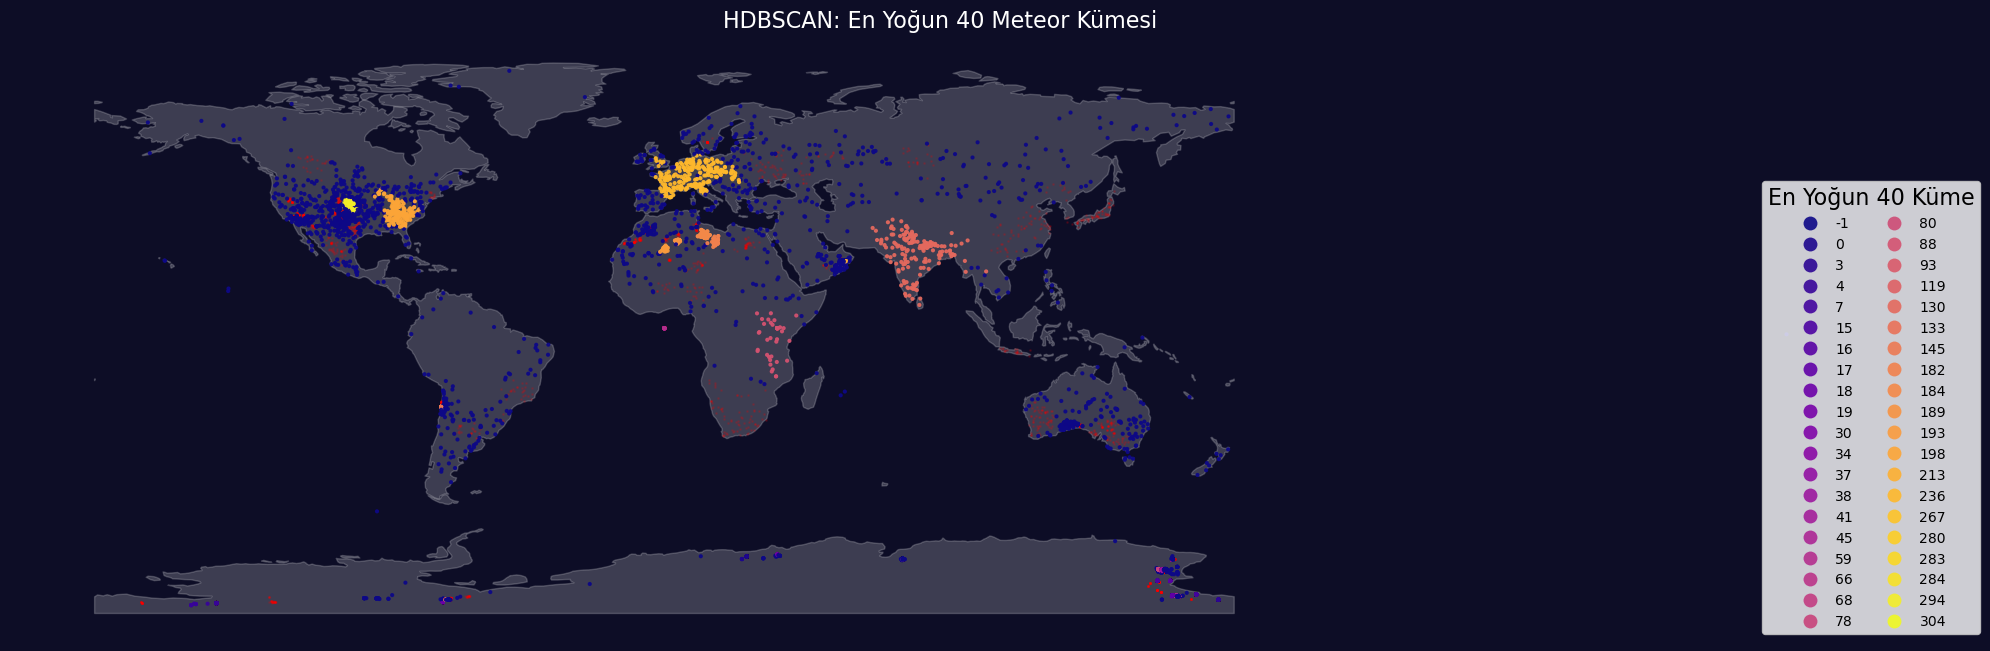

In [24]:
import hdbscan
import numpy as np

# 1️⃣ Meteor koordinatlarını numpy dizisine al
coords = np.array(list(zip(meteor_gdf.geometry.x, meteor_gdf.geometry.y)))

# 2️⃣ HDBSCAN modeli (minimum kümelenme örneği = 10, değiştirilebilir)
hdb = hdbscan.HDBSCAN(min_cluster_size=10)
hdb.fit(coords)

# 3️⃣ Küme etiketlerini ekle
meteor_gdf['hdbscan_cluster'] = hdb.labels_

import matplotlib.pyplot as plt
import geopandas as gpd
from geodatasets import get_path

# Dünya haritası
world = gpd.read_file(get_path("naturalearth.land"))

# 🔢 En yoğun 40 kümeyi seç
top_40_clusters = meteor_gdf['hdbscan_cluster'].value_counts().head(40).index
meteor_top40 = meteor_gdf[meteor_gdf['hdbscan_cluster'].isin(top_40_clusters)]
meteor_other = meteor_gdf[~meteor_gdf['hdbscan_cluster'].isin(top_40_clusters)]

# 🔍 Harita çizimi
fig, ax = plt.subplots(figsize=(20, 12))
fig.patch.set_facecolor('#0d0d26')

# Dünya katmanı
world.plot(ax=ax, color='white', edgecolor='white', alpha=0.2)

# Diğer tüm meteor noktalarını gri göster
meteor_other.plot(ax=ax, markersize=1, color='red', alpha=0.15)

# En yoğun 40 kümeyi renkli göster (legend daha büyük ve 2 sütun)
meteor_top40.plot(
    ax=ax,
    column='hdbscan_cluster',
    categorical=True,
    cmap='plasma',
    markersize=4,
    alpha=0.9,
    legend=True,
    legend_kwds={
        'loc': 'lower center',              # Alt merkeze konumlandır
        'bbox_to_anchor': (1, 0),      # Haritanın dışına taşır (yukarıdan aşağı)
        'title': 'En Yoğun 40 Küme',
        'ncol': 2,                          # 2 sütunlu görünüm
        'frameon': True,
        'fontsize': 10,                    # Yazı boyutu büyütülebilir
        'title_fontsize': 16
    }
)


plt.title("HDBSCAN: En Yoğun 40 Meteor Kümesi", fontsize=16, color='white')
ax.set_facecolor('#0d0d26')
ax.tick_params(colors='white')
plt.axis('off')
plt.tight_layout()
plt.show()


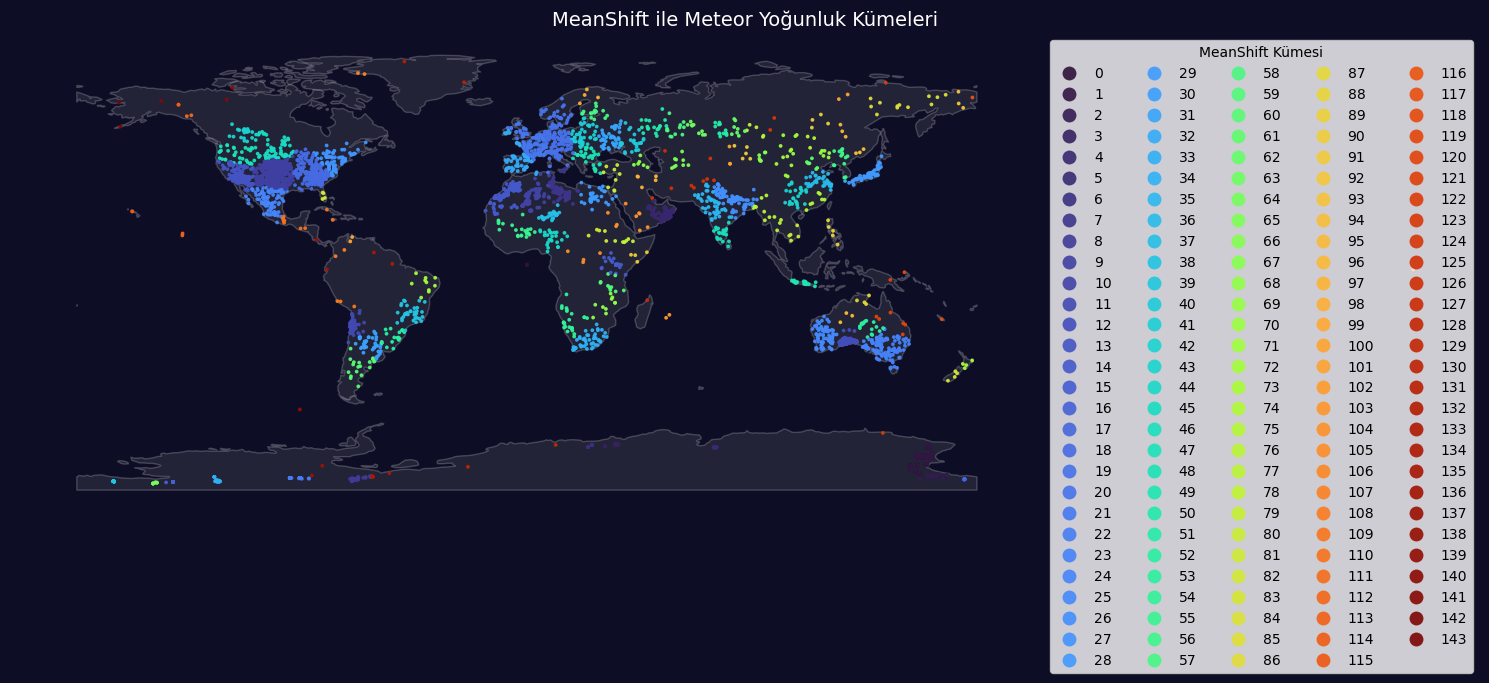

In [29]:
from sklearn.cluster import MeanShift
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
from geodatasets import get_path

# 1️⃣ Meteor verisi (GeoDataFrame olarak zaten var: meteor_gdf)
# EPSG:4326 olmalı, yoksa dönüştür:
if meteor_gdf.crs.to_epsg() != 4326:
    meteor_gdf = meteor_gdf.to_crs(epsg=4326)

# 2️⃣ Koordinatları numpy dizisine çevir
coords = np.array(list(zip(meteor_gdf.geometry.x, meteor_gdf.geometry.y)))

# 3️⃣ MeanShift modelini eğit (bandwidth = yaklaşık 5 derece)
meanshift = MeanShift(bandwidth=5)
meanshift.fit(coords)

# 4️⃣ Küme etiketlerini ekle
meteor_gdf['meanshift_cluster'] = meanshift.labels_

# 5️⃣ Dünya haritasını hazırla
world = gpd.read_file(get_path("naturalearth.land"))

# 6️⃣ Harita çizimi
fig, ax = plt.subplots(figsize=(15, 10))
fig.patch.set_facecolor('#0d0d26')
world.plot(ax=ax, color='gray', edgecolor='white', alpha=0.2)

# 7️⃣ Kümelenmiş meteor noktalarını çiz
meteor_gdf.plot(
    ax=ax,
    column='meanshift_cluster',
    categorical=True,
    legend=True,
    cmap='turbo',
    markersize=3,
    alpha=0.9,
    legend_kwds={'title': 'MeanShift Kümesi', 'ncol': 5,}
)

plt.title("MeanShift ile Meteor Yoğunluk Kümeleri", fontsize=14, color='white')
ax.set_facecolor('#0d0d26')
ax.tick_params(colors='white')
plt.axis('off')
plt.tight_layout()
plt.show()


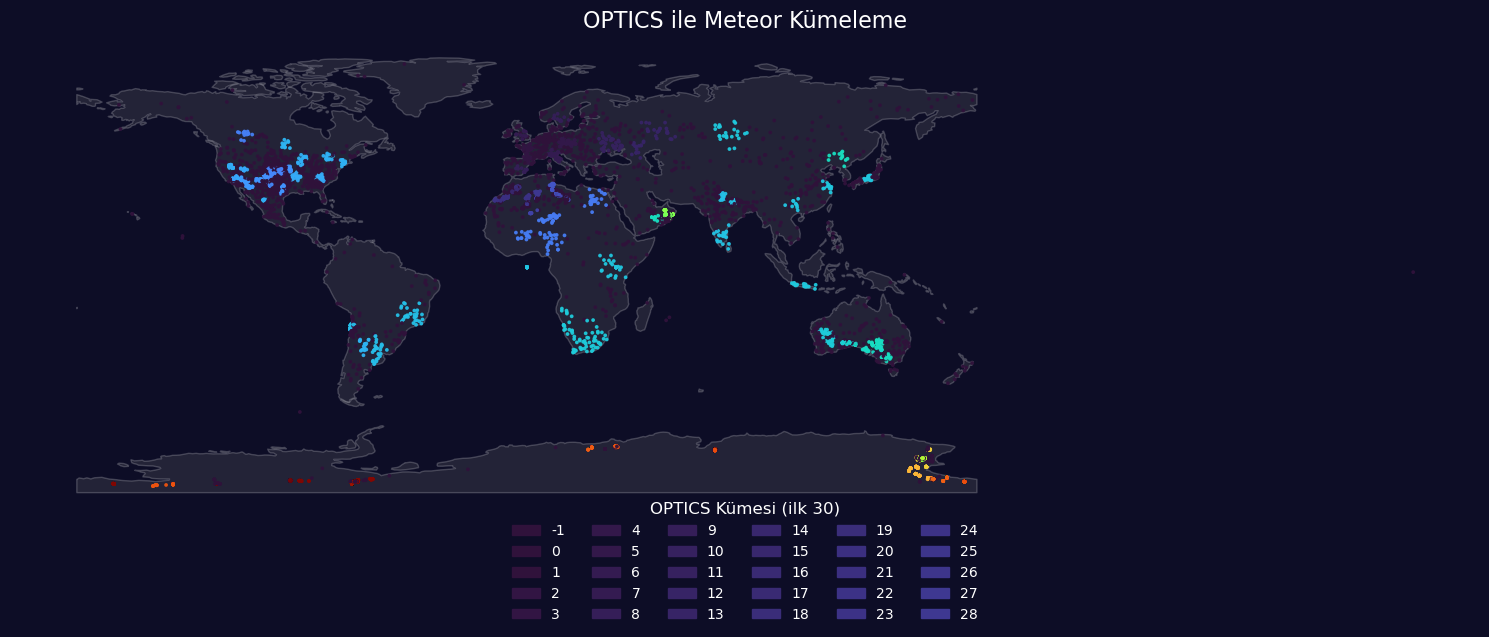

In [40]:
import matplotlib.patches as mpatches
import matplotlib.cm as cm
import matplotlib.colors as mcolors

# Küme renkleri
unique_clusters = sorted(meteor_gdf['optics_cluster'].unique())
top_n = 30  # Legend'da gösterilecek küme sayısı

# Daha canlı colormap
cmap = plt.get_cmap("turbo", len(unique_clusters))
colors = [cmap(i) for i in range(len(unique_clusters))]

# Renk eşlemesi
color_map = {cluster: colors[i] for i, cluster in enumerate(unique_clusters)}
meteor_gdf['cluster_color'] = meteor_gdf['optics_cluster'].map(color_map)

# Harita çizimi
fig, ax = plt.subplots(figsize=(15, 10))
fig.patch.set_facecolor('#0d0d26')
world.plot(ax=ax, color='gray', edgecolor='white', alpha=0.2)

meteor_gdf.plot(
    ax=ax,
    color=meteor_gdf['cluster_color'],
    markersize=3,
    alpha=0.9,
    legend=False
)

# Manuel legend - Beyaz metinlerle
patches = [
    mpatches.Patch(color=color_map[cluster], label=f"{cluster}")
    for cluster in unique_clusters[:top_n]
]
legend = plt.legend(
    handles=patches,
    title="OPTICS Kümesi (ilk 30)",
    loc='lower center',
    bbox_to_anchor=(0.5, -0.25),
    ncol=6,
    frameon=False,
    labelcolor='white',
    fontsize='medium',
    title_fontsize='large'
)

# 🎨 Legend başlığı beyaz yapmak için:
plt.setp(legend.get_title(), color='white')

# Stil
plt.title("OPTICS ile Meteor Kümeleme", fontsize=16, color='white')
ax.set_facecolor('#0d0d26')
ax.tick_params(colors='white')
plt.axis('off')
plt.tight_layout()
plt.show()


# 🔹 Mekânsal Regresyon

### GWR (Geographically Weighted Regression)

### Spatial Lag Model

### Spatial Error Model

🔧 GWR için en uygun bandwidth: 16.0


C:\Users\yalaz\AppData\Local\Temp\ipykernel_24284\3593477389.py:70: UserWarning: Glyph 128205 (\N{ROUND PUSHPIN}) missing from current font.
  plt.tight_layout()
C:\Users\yalaz\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128205 (\N{ROUND PUSHPIN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


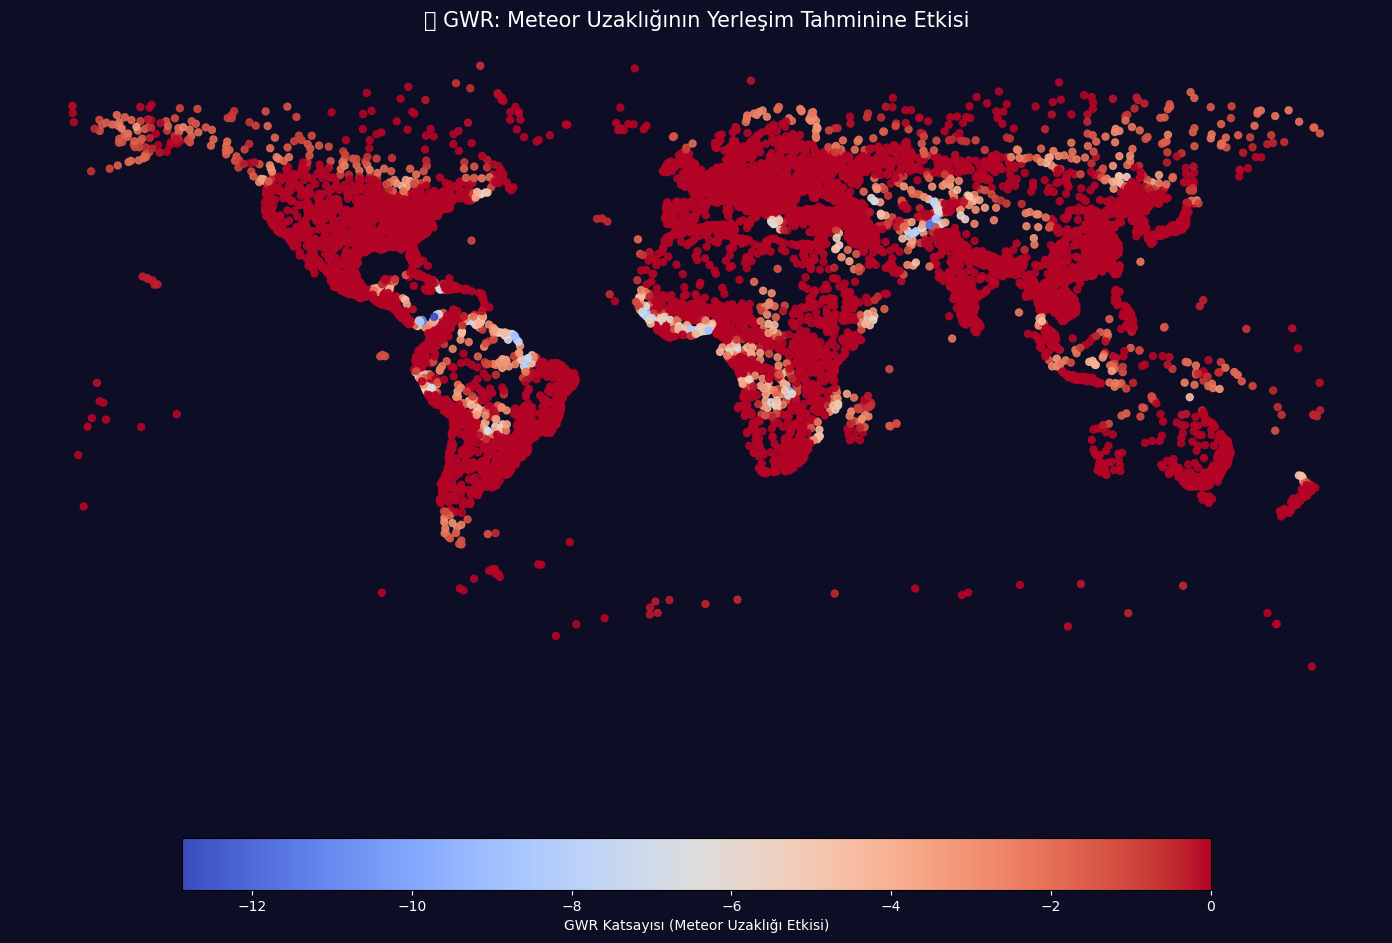

In [51]:
# 📦 Gerekli kütüphaneler
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mgwr.gwr import GWR
from mgwr.sel_bw import Sel_BW
from libpysal.weights import KNN
from shapely.geometry import Point

# 1️⃣ Şehir verisini EPSG:4326 formatında al
cities_gdf = cities_proj.to_crs(epsg=4326).copy()

# 2️⃣ Eksik sütunu ekle: Meteora yakınlık (500 km'den az)
cities_gdf['near_meteor'] = (cities_gdf['min_meteor_distance_m'] < 500_000).astype(int)

# 3️⃣ Koordinatları çıkar
cities_gdf['X'] = cities_gdf.geometry.x
cities_gdf['Y'] = cities_gdf.geometry.y

# 4️⃣ Girdi ve hedef değişkenler
coords = cities_gdf[['X', 'Y']].values
y = cities_gdf['near_meteor'].values.reshape((-1, 1))
X = cities_gdf[['min_meteor_distance_m']].values

# 5️⃣ Bağımsız değişkeni normalize et
X = (X - X.mean(axis=0)) / X.std(axis=0)

# 6️⃣ Bandwidth seçimi
selector = Sel_BW(coords, y, X)
bw = selector.search(bw_min=2)
print(f"🔧 GWR için en uygun bandwidth: {bw}")

# 7️⃣ GWR modeli
gwr_model = GWR(coords, y, X, bw)
gwr_results = gwr_model.fit()

# 8️⃣ Sadece 1. sütundaki (mesafe) beta katsayılarını al
cities_gdf['gwr_beta'] = gwr_results.params[:, 1]

# 9️⃣ Haritada katsayıları görselleştir
fig, ax = plt.subplots(figsize=(15, 10))
fig.patch.set_facecolor('#0d0d26')

# Harita çizimi ve legend objesini yakalama
plot = cities_gdf.plot(
    ax=ax,
    column='gwr_beta',
    cmap='coolwarm',
    legend=True,
    markersize=25,
    alpha=0.9,
    legend_kwds={
        'label': "GWR Katsayısı (Meteor Uzaklığı Etkisi)",
        'orientation': "horizontal",
        'shrink': 0.7
    }
)

# Colorbar etiketini beyaz yapmak için erişim
cbar = plot.get_figure().get_axes()[-1]
cbar.xaxis.label.set_color('white')  # etiket rengi
cbar.tick_params(colors='white')     # değer etiketlerinin rengi

# Harita stil ayarları
plt.title("📍 GWR: Meteor Uzaklığının Yerleşim Tahminine Etkisi", color='white', fontsize=15)
ax.set_facecolor('#0d0d26')
ax.tick_params(colors='white')
plt.axis('off')
plt.tight_layout()
plt.show()


In [9]:
import geopandas as gpd
import pandas as pd
import numpy as np
from libpysal.weights import KNN
from spreg import ML_Lag
from sklearn.preprocessing import StandardScaler

# 🔁 Eksikse veri dosyasını yeniden oku
cities_proj = gpd.read_file("../data/processed/cities_proj.geojson")

# 1️⃣ Veri hazırlığı
cities_gdf = cities_proj.to_crs(epsg=4326).copy()
cities_gdf['near_meteor'] = (cities_gdf['min_meteor_distance_m'] < 500_000).astype(int)


# 2️⃣ Koordinatlar (komşuluk matrisleri için)
coords = np.column_stack((cities_gdf.geometry.x, cities_gdf.geometry.y))

# 3️⃣ Komşuluk matrisi (5 en yakın komşu)
w = KNN.from_array(coords, k=5)
w.transform = 'r'  # Row-standardize: her satırın toplamı 1 olur

# 4️⃣ Bağımlı ve bağımsız değişkenler
y = cities_gdf[['near_meteor']].values
X = cities_gdf[['min_meteor_distance_m']].values

# 5️⃣ Normalize et (tercihe bağlı ama önerilir)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 6️⃣ Spatial Lag Model eğitimi
lag_model = ML_Lag(
    y, X_scaled, w=w,
    name_y='near_meteor',
    name_x=['min_meteor_distance_m'],
    name_w='KNN5'
)

# 7️⃣ Model sonuçları
print("📊 Spatial Lag Model Sonuçları")
print(f"Log-Likelihood: {lag_model.logll:.4f}")
print(f"Pseudo R²      : {lag_model.pr2:.4f}")
print(f"Rho (spatial lag etkisi): {lag_model.rho:.4f}")

# 8️⃣ Değişkenin etkisi (katsayı ve hata)
beta = lag_model.betas[1][0]
std_err = lag_model.std_err[1]
t_stat = beta / std_err

print(f"Coef (min_meteor_distance_m): {beta:.4f}")
print(f"Std Error: {std_err:.4f}")
print(f"T-statistic: {t_stat:.4f}")


C:\Users\yalaz\anaconda3\Lib\site-packages\libpysal\weights\distance.py:153: UserWarning: The weights matrix is not fully connected: 
 There are 7 disconnected components.
  W.__init__(self, neighbors, id_order=ids, **kwargs)
C:\Users\yalaz\anaconda3\Lib\site-packages\spreg\ml_lag.py:710: RuntimeWarning: divide by zero encountered in log
  jacob = np.log(np.linalg.det(a))


📊 Spatial Lag Model Sonuçları
Log-Likelihood: 2395.5055
Pseudo R²      : 0.8143
Rho (spatial lag etkisi): 0.8460
Coef (min_meteor_distance_m): -0.0250
Std Error: 0.0018
T-statistic: -13.5291


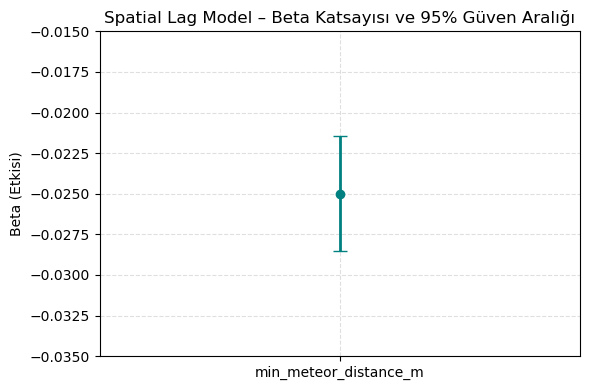

In [18]:
import matplotlib.pyplot as plt

# Beta ve hata değerleri
beta = -0.0250
std_err = 0.0018
ci_low = beta - 1.96 * std_err
ci_high = beta + 1.96 * std_err

# Grafik
plt.figure(figsize=(6, 4))
plt.errorbar(
    x=['min_meteor_distance_m'],
    y=[beta],
    yerr=[[beta - ci_low], [ci_high - beta]],
    fmt='o',
    color='teal',
    capsize=5,
    linewidth=2
)

plt.axhline(0, color='gray', linestyle='--')
plt.title("Spatial Lag Model – Beta Katsayısı ve 95% Güven Aralığı")
plt.ylabel("Beta (Etkisi)")
plt.ylim(beta - 0.01, beta + 0.01)  # Zoom effect
plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()


In [21]:
# 📦 Kütüphaneler
import geopandas as gpd
import numpy as np
from libpysal.weights import KNN
from spreg import ML_Error
from sklearn.preprocessing import StandardScaler

# 1️⃣ Veri okuma ve hazırlık
cities_proj = gpd.read_file("../data/processed/cities_proj.geojson")
cities_gdf = cities_proj.to_crs(epsg=4326).copy()
cities_gdf['near_meteor'] = (cities_gdf['min_meteor_distance_m'] < 500_000).astype(int)

# 2️⃣ Koordinatlar (komşuluk matrisi için)
coords = np.column_stack((cities_gdf.geometry.x, cities_gdf.geometry.y))
w = KNN.from_array(coords, k=5)
w.transform = 'r'

# 3️⃣ Bağımlı ve bağımsız değişken
y = cities_gdf[['near_meteor']].values
X = cities_gdf[['min_meteor_distance_m']].values

# 4️⃣ Normalizasyon (standartlaştırma)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 5️⃣ Spatial Error Model eğitimi
error_model = ML_Error(
    y, X_scaled, w=w,
    name_y='near_meteor',
    name_x=['min_meteor_distance_m'],
    name_w='KNN5'
)

# 6️⃣ Sonuçları yazdır
print("📊 Spatial Error Model Sonuçları")
print(f"Log-Likelihood: {error_model.logll:.4f}")
print(f"Pseudo R²      : {error_model.pr2:.4f}")
print(f"Lambda (mekânsal hata etkisi): {error_model.lam:.4f}")
print(f"Coef (min_meteor_distance_m): {error_model.betas[1][0]:.4f}")
print(f"Std Error: {error_model.std_err[1]:.4f}")
print(f"T-Statistic: {error_model.betas[1][0] / error_model.std_err[1]:.4f}")


C:\Users\yalaz\anaconda3\Lib\site-packages\libpysal\weights\distance.py:153: UserWarning: The weights matrix is not fully connected: 
 There are 7 disconnected components.
  W.__init__(self, neighbors, id_order=ids, **kwargs)
C:\Users\yalaz\anaconda3\Lib\site-packages\scipy\optimize\_minimize.py:913: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
  warn("Method 'bounded' does not support relative tolerance in x; "
C:\Users\yalaz\anaconda3\Lib\site-packages\spreg\ml_error.py:563: RuntimeWarning: divide by zero encountered in log
  jacob = np.log(np.linalg.det(a))


📊 Spatial Error Model Sonuçları
Log-Likelihood: 2328.2671
Pseudo R²      : 0.0712
Lambda (mekânsal hata etkisi): 0.8460
Coef (min_meteor_distance_m): -0.0129
Std Error: 0.0019
T-Statistic: -6.8582


# 🔹 Nedensel / Açıklayıcı Modeller

### Bayesian Logistic Regression

### DoWhy

### CausalML

 Progress                    Draws   Divergences   Step size   Grad evals   Sampling Speed   Elapsed   Remaining  
 ───────────────────────────────────────────────────────────────────────────────────────────────────────────────── 
  ━━━━━━━━━━━━━━━━━━━━━━━━━   2000    639           0.14        18           108.33 draws/s   0:00:18   0:00:00    
  ━━━━━━━━━━━━━━━━━━━━━━━━━   2000    567           0.05        58           66.63 draws/s    0:00:30   0:00:00    
  ━━━━━━━━━━━━━━━━━━━━━━━━━   2000    748           0.10        8            62.75 draws/s    0:00:31   0:00:00    
  ━━━━━━━━━━━━━━━━━━━━━━━━━   2000    884           0.01        177          48.59 draws/s    0:00:41   0:00:00

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 60 seconds.
There were 2838 divergences after tuning. Increase `target_accept` or reparameterize.


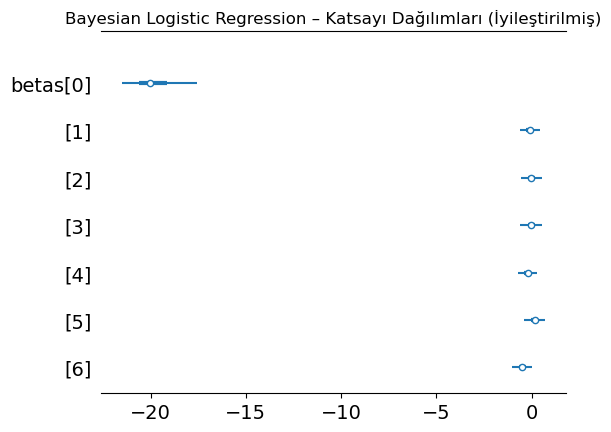

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
betas[0],-19.776,1.112,-21.495,-17.551,0.052,0.029,417.0,537.0,1.00
betas[1],-0.096,0.280,-0.616,0.464,0.011,0.006,706.0,1096.0,1.00
betas[2],-0.014,0.277,-0.544,0.525,0.013,0.013,571.0,325.0,1.00
betas[3],-0.021,0.283,-0.582,0.525,0.010,0.007,779.0,1066.0,1.00
betas[4],-0.190,0.269,-0.720,0.309,0.010,0.006,719.0,1095.0,1.00
betas[5],0.157,0.280,-0.394,0.706,0.011,0.008,615.0,652.0,1.01
betas[6],-0.484,0.280,-1.050,0.040,0.010,0.008,802.0,943.0,1.01


In [5]:
import pymc as pm
import arviz as az
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Varsayımsal veri (kendi clean_data'n ile değiştir)
np.random.seed(42)
n = 1000
clean_data = pd.DataFrame({
    'min_meteor_distance_m': np.random.uniform(0, 1e6, n),
    'continent_Asia': np.random.randint(0, 2, n),
    'continent_Europe': np.random.randint(0, 2, n),
    'continent_Africa': np.random.randint(0, 2, n),
    'continent_Australia': np.random.randint(0, 2, n),
    'continent_North America': np.random.randint(0, 2, n),
    'continent_South America': np.random.randint(0, 2, n),
})
clean_data['near_meteor'] = (clean_data['min_meteor_distance_m'] < 5e5).astype(int)

# Özellikler ve hedef
feature_cols = ['min_meteor_distance_m'] + [col for col in clean_data.columns if col.startswith('continent_')]
X = clean_data[feature_cols]
y = clean_data['near_meteor'].values

# Standartlaştır
scaler = StandardScaler()
X_scaled_np = scaler.fit_transform(X)

# Bayesian Logistic Regression modeli
with pm.Model() as bayes_model:
    intercept = pm.Normal("intercept", mu=0, sigma=5)
    coefs = pm.Normal("betas", mu=0, sigma=5, shape=X_scaled_np.shape[1])

    logits = intercept + pm.math.dot(X_scaled_np, coefs)
    theta = pm.Deterministic("theta", pm.math.sigmoid(logits))
    obs = pm.Bernoulli("obs", p=theta, observed=y)

    trace = pm.sample(1000, tune=1000, target_accept=0.95, return_inferencedata=True, chains=4)

# Sonuçları görselleştir
az.plot_forest(trace, var_names=["betas"], combined=True, hdi_prob=0.95)
plt.title("Bayesian Logistic Regression – Katsayı Dağılımları (İyileştirilmiş)")
plt.show()

# Özet tablo
az.summary(trace, var_names=["betas"], hdi_prob=0.95)


In [9]:
import pandas as pd
import numpy as np
from dowhy import CausalModel
import matplotlib.pyplot as plt

# Veri seti oluştur (örnekleme dayalı; kendi clean_data’n ile değiştir)
np.random.seed(42)
size = 1000
clean_data = pd.DataFrame({
    'min_meteor_distance_m': np.random.uniform(0, 1_000_000, size),
    'continent_Europe': np.random.randint(0, 2, size),
    'continent_Asia': np.random.randint(0, 2, size),
    'continent_Africa': np.random.randint(0, 2, size),
    'continent_North America': np.random.randint(0, 2, size),
    'continent_South America': np.random.randint(0, 2, size),
})
clean_data['near_meteor'] = (clean_data['min_meteor_distance_m'] < 500_000).astype(int)

# 1️⃣ Modeli oluştur
model = CausalModel(
    data=clean_data,
    treatment="min_meteor_distance_m",
    outcome="near_meteor",
    common_causes=["continent_Europe", "continent_Asia", "continent_Africa", 
                   "continent_North America", "continent_South America"]
)

# 2️⃣ Etkiyi tanımla
identified_estimand = model.identify_effect()

# 3️⃣ Nedensel etkiyi hesapla
causal_estimate = model.estimate_effect(identified_estimand,
                                        method_name="backdoor.linear_regression")

# 4️⃣ Refütasyon testi (placebo etkisi kontrolü)
refutation = model.refute_estimate(identified_estimand, causal_estimate,
                                   method_name="placebo_treatment_refuter")

# 5️⃣ Sonuçları yazdır
print("🎯 Causal Effect Estimate:", causal_estimate.value)
print("🧪 Refutation Test:\n", refutation)


🎯 Causal Effect Estimate: -1.4883521211039863e-06
🧪 Refutation Test:
 Refute: Use a Placebo Treatment
Estimated effect:-1.4883521211039863e-06
New effect:-1.1102230246251565e-16
p value:0.0



🎯 Ortalama Nedensel Etki (ATE): 0.036


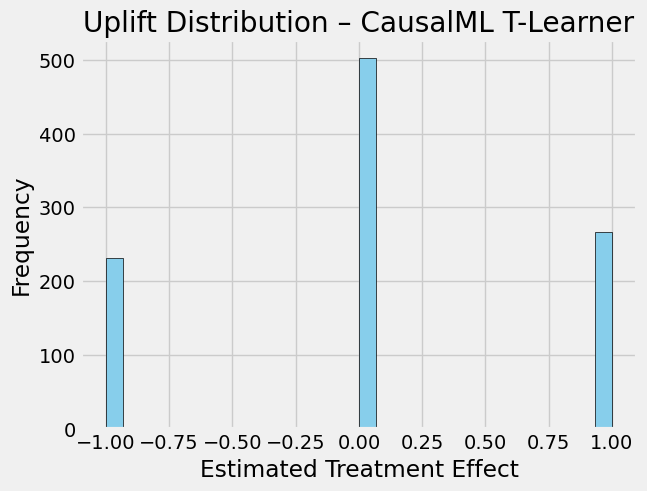

In [7]:
#CausalML

import pandas as pd
import numpy as np
from causalml.inference.meta import BaseTClassifier
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt

# 1️⃣ Örnek veri üret (dengeli olacak şekilde)
np.random.seed(42)
n = 1000
continents = ['Europe', 'Asia', 'Africa', 'North America', 'South America']
continent_data = {f'continent_{c}': np.random.randint(0, 2, n) for c in continents}

clean_data = pd.DataFrame(continent_data)
clean_data['treatment'] = np.random.randint(0, 2, n)
clean_data['near_meteor'] = (
    clean_data['treatment'] * clean_data['continent_Europe'] +
    (1 - clean_data['treatment']) * clean_data['continent_Asia']
).apply(lambda x: 1 if x > 0 else 0)

# 2️⃣ Özellik seti
X = clean_data[[f'continent_{c}' for c in continents]]
treatment = clean_data['treatment']
y = clean_data['near_meteor']

# 🔍 Kontrollü dağılım kontrolü
assert y.nunique() == 2
assert clean_data[clean_data['treatment'] == 1]['near_meteor'].nunique() == 2
assert clean_data[clean_data['treatment'] == 0]['near_meteor'].nunique() == 2

# 3️⃣ Modelleme
learner = BaseTClassifier(learner=RandomForestClassifier(), control_name=0)
learner.fit(X=X.values, treatment=treatment.values, y=y.values)

# 4️⃣ Tahmin ve ATE
te = learner.predict(X=X.values, treatment=treatment.values)
print("🎯 Ortalama Nedensel Etki (ATE):", np.mean(te))

# 5️⃣ Görselleştirme
plt.hist(te, bins=30, color="skyblue", edgecolor="black")
plt.title("Uplift Distribution – CausalML T-Learner")
plt.xlabel("Estimated Treatment Effect")
plt.ylabel("Frequency")
plt.show()


Zaman + Mekân Modelleri
ConvLSTM

Epoch 1/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.5449 - loss: 0.7385
Epoch 2/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step - accuracy: 0.5718 - loss: 0.6940
Epoch 3/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - accuracy: 0.5972 - loss: 0.6757
Epoch 4/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step - accuracy: 0.6445 - loss: 0.6598
Epoch 5/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step - accuracy: 0.7002 - loss: 0.6469


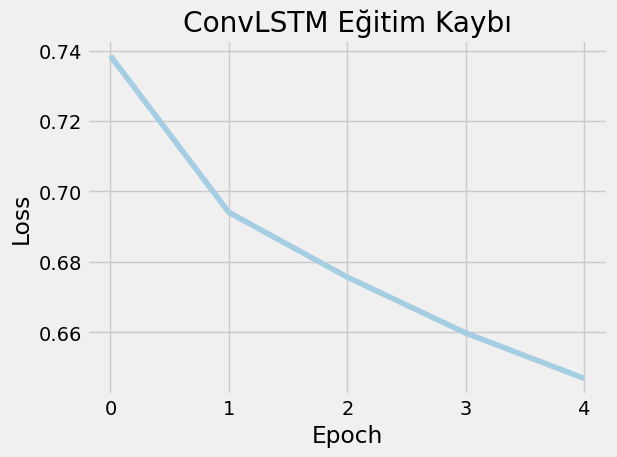

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import ConvLSTM2D, BatchNormalization, Conv2D

# 🔹 1. Veri Hazırlığı (Zaman, Grid, Kanal)
time_steps = 141
grid_h, grid_w = 32, 64
feature_count = 1

# Random veriyi 5D ConvLSTM formatına sokalım
np.random.seed(42)
data = np.random.rand(time_steps, grid_h, grid_w, feature_count)
X_conv = np.expand_dims(data, axis=0)  # shape: (1, 141, 32, 64, 1)
y_conv = np.array([1])  # Dummy hedef (binary sınıflandırma)

# 🔹 2. Model Tanımı
model = Sequential()
model.add(ConvLSTM2D(filters=16, kernel_size=(3, 3), input_shape=(time_steps, grid_h, grid_w, feature_count),
                     padding='same', return_sequences=False))
model.add(BatchNormalization())
model.add(Conv2D(filters=1, kernel_size=(3, 3), activation='sigmoid', padding='same'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# y_conv'u modelin çıktısına uygun hale getir
y_conv = np.zeros((1, 32, 64, 1), dtype=np.float32)

# 🔹 3. Eğitim
history = model.fit(X_conv, y_conv, epochs=5, batch_size=1, verbose=1)

# 🔹 4. Eğitim Kaybı Grafiği
plt.plot(history.history['loss'])
plt.title("ConvLSTM Eğitim Kaybı")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.tight_layout()
plt.show()
